In [1]:
%cd /home/novelli/encoderops

/home/novelli/encoderops


In [2]:
import treescope
import torch
from dotenv import load_dotenv
from pathlib import Path
from src.model import EvolutionOperator
from src.data import CalixareneDataset
from src.configs import ModelArgs # noqa
from torch.utils.data import RandomSampler, ConcatDataset
from torch_geometric.loader import DataLoader
from loguru import logger
from dataclasses import asdict
import linear_operator_learning as lol
import matplotlib.pyplot as plt
from src.data import mdtraj_load
import numpy as np
import os
from analysis.descriptors import compute_descriptors
import wandb
load_dotenv()

#treescope.basic_interactive_setup()


protein_id = "G1"
traj_id = 0
api = wandb.Api()

for run in api.runs(f"csml/encoderops-{protein_id}"):
    updated: bool = False
    if run.state == "finished":
        data_path = Path(f"logs/encoderops-{protein_id}/{run.id}")
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob("**/last.ckpt")))
        model_args = asdict(model.model_args)
        for k, v in model_args.items():
            if k not in run.config:
                run.config[k] = v
                updated = True
        run.update()
        if updated:
            logger.info(f"Updated run {run.id}")
        else:
            logger.info(f"Run {run.id} was already up to date")

def deterministic_sampler(dataset, subsample:float, seed: int, verbose: bool = True):
    generator = torch.Generator()
    generator.manual_seed(seed)
    num_samples = int(len(dataset)*subsample)
    if verbose:
        logger.info(f"Subsampling {num_samples} samples ({num_samples/len(dataset):.3f}%)")
    sampler = RandomSampler(dataset, num_samples=num_samples, generator=generator)
    return sampler


def load_run(run_id: str, protein_id: str, traj_id:int = 0, epoch: int | None = None, progress: bool = True, subsample: float | None = None):
    reg=1e-4
    rng_seed = 42
    batch_size = 1024
    data_path = Path(f"logs/encoderops-{protein_id}/{run_id}")
    if epoch is None:
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob("**/last.ckpt")))
    else:
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
    if isinstance(model.data_args.traj_id, list):
            datasets = [
                CalixareneDataset(
                    model.data_args.protein_id,
                    traj_id=traj_id,
                    lagtime=model.data_args.lagtime,
                    _keep_mdtraj=True
                )
                for traj_id in model.data_args.traj_id
            ]
            dataset = ConcatDataset(datasets)
            dataset.cutoff = dataset.datasets[0].cutoff
            dataset.lagtime_ns = dataset.datasets[0].lagtime_ns
            dataset.protein_id = dataset.datasets[0].protein_id
            dataset.z_table = dataset.datasets[0].z_table
    embeddings = {"t": [], "lag": []}
    model = model.eval()
    if subsample is not None:
        num_samples = int(len(dataset)*subsample)
        logger.info(f"Subsampling {num_samples} samples ({num_samples/len(dataset):.3f}%)")
        sample_idxs = [idx for idx in deterministic_sampler(dataset, subsample, rng_seed, verbose=False)]
        sampler = deterministic_sampler(dataset, subsample, rng_seed)
        dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    else:
        dataloader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False
        )
        sample_idxs = None

    with torch.no_grad():
        if progress:
            from tqdm.auto import tqdm
            dataloader = tqdm(dataloader)
        for batch in dataloader:
            for k, v in batch.items():
                batch[k] = v.to(model.device)
            # data
            x_t = model._setup_graph_data(batch)
            x_lag = model._setup_graph_data(batch, key="item_lag")
            # forward
            f_t = model.forward_nn(x_t)
            f_lag = model.forward_nn(x_lag)
            embeddings["t"].append((f_t.detach().cpu()))
            embeddings["lag"].append((f_lag.detach().cpu()))
    phi_t = torch.cat(embeddings["t"])
    phi_lag = torch.cat(embeddings["lag"])
    logger.info(f"model mean {model.f_mean}\nstat mean {phi_t.mean(dim=0)}\n diff {model.f_mean.to('cpu') - phi_t.mean(dim=0)}")
    cov_X = model.cov.to('cpu')
    cov_X += torch.eye(cov_X.shape[0], device=cov_X.device) * reg
    cov_XY = model.cross_cov.to('cpu')
    G = torch.linalg.solve(cov_X, cov_XY)
    l, Q = torch.linalg.eig(G) # Q @ torch.diag(l) @ Q^-1 = G
    sort_perm = torch.argsort(l.abs(), descending=True)
    l = l[sort_perm]
    Q = Q[:, sort_perm]
    r_fun = phi_t.to(dtype=Q.dtype) @ Q 
    results = {
        "embedding_t": phi_t,
        "embedding_lag": phi_lag,
        "eigenvalues": l,
        "eigenvectors": Q,
        "r_fun": r_fun,
        "sample_idxs": sample_idxs
    }
    return model, results, dataset

def descriptors(dataset, sample_idxs: list[int] | None, descriptors=['dihedrals']):
    import bisect
    import mdtraj

    configs = []
    for idx in sample_idxs:
        if idx < 0:
            if -idx > len(dataset):
                raise ValueError(
                    "absolute value of index should not exceed dataset length"
                )
            idx = len(dataset) + idx
        dataset_idx = bisect.bisect_right(dataset.cumulative_sizes, idx)
        if dataset_idx == 0:
            sample_idx = idx
        else:
            sample_idx = idx - dataset.cumulative_sizes[dataset_idx - 1]
        configs.append(dataset.datasets[dataset_idx].traj[sample_idx])
    traj = mdtraj.join(configs)
    print(traj)
    descriptors_df, feats_info = compute_descriptors(traj, descriptors)
    return traj, descriptors_df, feats_info

2025-05-09 15:51:48.396 | INFO     | __main__:<module>:42 - Run q6eu8zd2 was already up to date


In [3]:
protein_id = "G1"

run_id = "64ssb2nm"
subsample = 0.04

model, results, dataset = load_run(run_id, protein_id, subsample=subsample)

2025-05-09 15:52:21.836 | INFO     | src.data:__init__:56 - System selection: all and not type H
2025-05-09 15:52:23.425 | INFO     | src.data:__init__:56 - System selection: all and not type H
2025-05-09 15:52:24.995 | INFO     | src.data:__init__:56 - System selection: all and not type H
2025-05-09 15:52:26.054 | INFO     | src.data:__init__:56 - System selection: all and not type H
2025-05-09 15:52:26.597 | INFO     | src.data:__init__:56 - System selection: all and not type H
2025-05-09 15:52:27.593 | INFO     | src.data:__init__:56 - System selection: all and not type H
2025-05-09 15:52:28.155 | INFO     | src.data:__init__:56 - System selection: all and not type H
2025-05-09 15:52:28.765 | INFO     | src.data:__init__:56 - System selection: all and not type H
2025-05-09 15:52:29.156 | INFO     | src.data:__init__:56 - System selection: all and not type H
2025-05-09 15:52:29.631 | INFO     | src.data:__init__:56 - System selection: all and not type H
2025-05-09 15:52:29.861 | INFO

  0%|          | 0/9 [00:00<?, ?it/s]

2025-05-09 15:53:01.638 | INFO     | __main__:load_run:109 - model mean tensor([0.2689, 0.2275, 0.2694, 0.2341, 0.2559, 0.2482, 0.2460, 0.2499, 0.2505,
        0.2572, 0.2552, 0.2370, 0.2246, 0.2405, 0.2788, 0.2560, 0.2546, 0.2458,
        0.2623, 0.2373, 0.2464, 0.2363, 0.2661, 0.2512, 0.2471, 0.2539, 0.2406,
        0.2584, 0.2476, 0.2580, 0.2599, 0.2345, 0.2360, 0.2766, 0.2506, 0.2368,
        0.2492, 0.2447, 0.2432, 0.2629, 0.2696, 0.2417, 0.2617, 0.2270, 0.2672,
        0.2476, 0.2472, 0.2380, 0.2407, 0.2565, 0.2409, 0.2619, 0.2507, 0.2514,
        0.2538, 0.2441, 0.2464, 0.2729, 0.2425, 0.2382, 0.2721, 0.2491, 0.2262,
        0.2526], device='cuda:0')
stat mean tensor([0.2516, 0.2594, 0.2469, 0.2421, 0.2912, 0.2538, 0.2429, 0.2121, 0.2559,
        0.2442, 0.2696, 0.2304, 0.2070, 0.2540, 0.2678, 0.2711, 0.2746, 0.2281,
        0.2595, 0.2378, 0.2676, 0.2233, 0.2762, 0.2330, 0.2419, 0.2571, 0.2742,
        0.2268, 0.2454, 0.2464, 0.2355, 0.2727, 0.2260, 0.2738, 0.2737, 0.2265,
    

In [4]:
for ds_id, ds in enumerate(dataset.datasets):
    print(f"{ds_id} -> {len(ds)*1e-3:.0f} ns ({len(ds)} samples)")

0 -> 40 ns (39857 samples)
1 -> 35 ns (35044 samples)
2 -> 29 ns (28864 samples)
3 -> 18 ns (17608 samples)
4 -> 15 ns (15035 samples)
5 -> 30 ns (29678 samples)
6 -> 11 ns (10741 samples)
7 -> 24 ns (24132 samples)
8 -> 6 ns (5606 samples)
9 -> 20 ns (20011 samples)


In [5]:
#traj, desc_df, feats_info = descriptors(dataset, sample_idxs=results['sample_idxs'], descriptors=['hbonds_distances'])

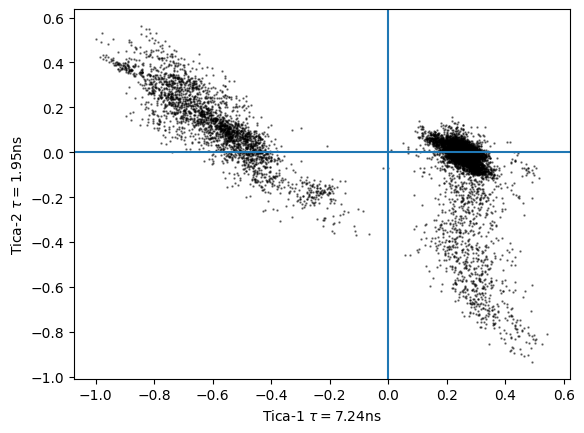

In [14]:
r_fun = results['r_fun'].real
def implied_timescale(ev, lagtime_ns: float = 0.5):
    if torch.is_tensor(ev):
        ev = ev.numpy(force=True)
    timescale = -1*(lagtime_ns / np.log(np.abs(ev)))
    return np.sort(timescale)[::-1]

idxs = (0, 1)
plt.scatter(r_fun[:, idxs[0]].real, r_fun[:, idxs[1]].real, color='k', s = 0.5, alpha=0.5)
taus = implied_timescale(results['eigenvalues'], lagtime_ns = dataset.datasets[0].lagtime_ns)
plt.xlabel(f'Tica-{idxs[0] + 1} $\\tau=${taus[idxs[0]]:.2f}ns')
plt.ylabel(f'Tica-{idxs[1] + 1} $\\tau=${taus[idxs[1]]:.2f}ns')
plt.axhline(0)
plt.axvline(0)

In [9]:
dataset.datasets[0].traj

<mdtraj.Trajectory with 40357 frames, 140 atoms, 2 residues, and unitcells at 0x7f82e0334910>

In [18]:
print(results['eigenvalues'])

tensor([ 9.9583e-01-1.4168e-04j,  9.9583e-01+1.4168e-04j,
         9.9414e-01+0.0000e+00j,  9.9352e-01+2.8930e-04j,
         9.9352e-01-2.8930e-04j,  9.9260e-01+0.0000e+00j,
         9.9206e-01+9.6843e-04j,  9.9206e-01-9.6843e-04j,
         9.9076e-01+4.9986e-04j,  9.9076e-01-4.9986e-04j,
         9.9028e-01+0.0000e+00j,  9.8973e-01-1.2505e-03j,
         9.8973e-01+1.2505e-03j,  9.8869e-01+0.0000e+00j,
         9.8862e-01+1.3732e-03j,  9.8862e-01-1.3732e-03j,
         9.8805e-01+6.6527e-04j,  9.8805e-01-6.6527e-04j,
         9.8657e-01-3.5138e-04j,  9.8657e-01+3.5138e-04j,
         9.8573e-01+0.0000e+00j,  9.8530e-01-1.3299e-03j,
         9.8530e-01+1.3299e-03j,  9.8485e-01+0.0000e+00j,
         9.8331e-01-6.1068e-05j,  9.8331e-01+6.1068e-05j,
         9.8216e-01+0.0000e+00j,  9.8140e-01+1.6057e-03j,
         9.8140e-01-1.6057e-03j,  9.8125e-01+0.0000e+00j,
         9.8041e-01-1.5762e-03j,  9.8041e-01+1.5762e-03j,
         9.7931e-01+0.0000e+00j,  9.7717e-01-1.2171e-03j,
         9.771

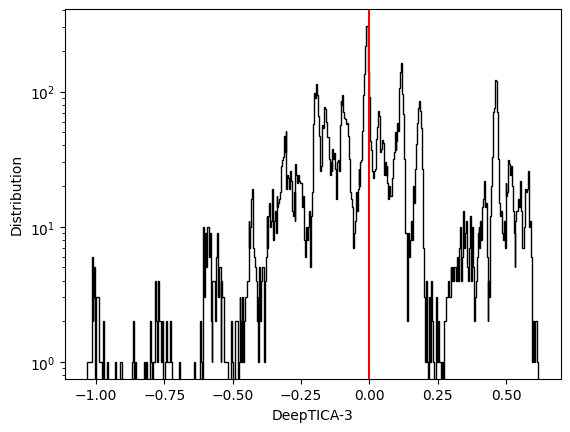

In [27]:
fig, ax = plt.subplots()
eigfun_idx = 2
mask = results['r_fun'][:, 0].real < 10
eigfun = results['r_fun'][:, eigfun_idx].real
ax.hist(eigfun[mask],bins=500,histtype='step', color='k')
ax.set_yscale('log')
ax.set_xlabel(f'DeepTICA-{eigfun_idx + 1}')
ax.set_ylabel('Distribution')
ax.axvline(0, color='r')

In [33]:
from mlcolvar.data import DictDataset
df = desc_df.copy()
labels = np.zeros(len(df))
# State 1
labels[np.argwhere(np.logical_and(eigfun < 0, mask))] = 1
# State 2
labels[np.argwhere(np.logical_and(eigfun > 0, mask))] = 2


df['labels'] = labels
sel = (df['labels'] != 0 )

descr_type = 'distances' #'angles' #'distances' #'angles' 
stride = 10

if descr_type == 'angles':
    # get descriptors
    X = df[sel].filter(regex='phi|psi|xi|theta').values[::stride]
    feat_names = df[sel].filter(regex='phi|psi|xi|theta').columns.values

    # get labels
    y = df[sel]['labels'].values[::stride]

elif descr_type == 'distances':
    # get descriptors
    X = df[sel].filter(regex='DIST').values[::stride]
    feat_names = df[sel].filter(regex='DIST').columns.values

    # get labels
    y = df[sel]['labels'].values[::stride]

# create dataset
dataset = DictDataset(dict(data=X,labels=y))
dataset.feature_names = feat_names
dataset

DictDataset( "data": [490, 318], "labels": [490], "data_type": descriptors )

In [34]:
from mlcolvar.explain.lasso import SparsityScoring, plot_lasso_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel

In [35]:
def lasso_classification(dataset,
                         min_features = 0,
                         Cs = 40,
                         scale_inputs = True,
                         feature_names = None,
                         print_info = True,
                         plot = True
):
    """Perform sparse classification via LASSO on a given DictDataset (requires keys: "data" and "labels").
    The (inverse) regularization strength C is automatically chosen based on cross-validation on a set of values (Cs),
    see sklearn.linear_model.LogisticRegressionCV. The scoring function used is `SparsityScoring`, balancing the accuracy and the number of features.

    In the two-classes case a single classifier is built, otherwise a one-vs-rest classifier is constructed, composed by N different estimators are trained to classify each state from the others.
    
    Parameters
    ----------
    dataset : DictDataset
        dataset with 'data' and 'labels'
    min_features : int, optional
        minimum number of features, by default 0
    Cs : int or array-like, optional
        Each of the values in Cs describes the inverse of regularization strength. If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4. Like in support vector machines, smaller values specify stronger regularization., by default 40
    scale_inputs : bool, optional
        whether to standardize inputs based on mean and std.dev., by default True
    feature_names : list, optional
        names of the input features, if not given they are taken from `dataset.feature_names`, by default None
    print_info : bool, optional
        whether to print results, by default True
    plot : bool, optional
        whether to plot results, by default True

    See also
    --------
    mlcolvar.explain.lasso.SparsityScoring
        Scoring function used in LASSO classification

    Returns
    -------
    classifier: 
        optimized estimator
    feats: 
        dictionary with the names of the non-zero features, per label
    coeffs: 
        dictionary with the coefficients of the non-zero features, per label
    """

    # Convert dataset to numpy
    with torch.no_grad():
        raw_descriptors = dataset['data'].numpy()
        labels = dataset['labels'].numpy().astype(int)
    if feature_names is None:
        if dataset.feature_names is None:
            raise ValueError('Feature names not found (either in the dataset or as argument to the function).')
        feature_names = dataset.feature_names
    
    # Scaling inputs
    if scale_inputs:
        scaler = StandardScaler(with_mean=True, with_std=True)
        descriptors = scaler.fit_transform(raw_descriptors)
    else:
        descriptors = raw_descriptors

    # Define cross-validation for LASSO, using
    #   a custom scoring function based on accuracy and number of features
    scorer = SparsityScoring(min_features=min_features) 

    _classifier = LogisticRegressionCV(Cs=Cs, 
                                    solver='liblinear', 
                                    multi_class='ovr', 
                                    fit_intercept=False, 
                                    penalty='l1',
                                    n_jobs=20, 
                                    max_iter = 200,
                                    scoring=scorer)

    # Fit classifier
    feature_selector = SelectFromModel(_classifier)
    feature_selector.fit(descriptors, labels)

    classifier = feature_selector.estimator_

    # Get selected features and coefficients 
    feats = {}
    coeffs = {}

    for i,key in enumerate(classifier.coefs_paths_.keys()):

        index = np.abs(classifier.coef_).argsort()[i][::-1]

        sorted_feature_names = feature_names[index]
        sorted_coeffs = classifier.coef_[i,index]

        idx = np.argwhere ( np.abs(sorted_coeffs)>1e-5 )[:,0]
        selected_feature_names = sorted_feature_names[idx]
        selected_coeffs = sorted_coeffs[idx] 
        feats[key] = selected_feature_names
        coeffs[key] = selected_coeffs

        # display summary
        if print_info:
            #score = classifier.score(descriptors,labels)
            C_idx = np.argwhere(np.abs(classifier.Cs_ - classifier.C_[i]) < 1e-8)[0,0]
            score = classifier.scores_[key].mean(axis=0)[C_idx]
            accuracy = classifier.scoring.accuracy_from_score(score, len(selected_coeffs))

            print(f'======= LASSO results ({key}) ========')
            print(f'- Regularization : {classifier.C_[i]:.8f}')
            print(f'- Score          : {score:.2f}')
            print(f'- Accuracy       : {accuracy*100:.2f}%')
            print(f'- # features     : {len(selected_coeffs)}\n')
            print('Features: ')
            for j,(f,c) in enumerate(zip(selected_feature_names, selected_coeffs)):
                print(f'({j+1}) {f:13s}: {c:.6f}')
            print('==================================\n')

    # plot results
    if plot:
        plot_lasso_classification(classifier, feats, coeffs)

    return classifier, feats, coeffs

/home/novelli/encoderops/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


======= LASSO results (2) ========
- Regularization : 0.00625055
- Score          : -2.06
- Accuracy       : 98.94%
- # features     : 1

Features: 
(1) HB_DIST PRO4-N -- GLU5-N: -0.512067



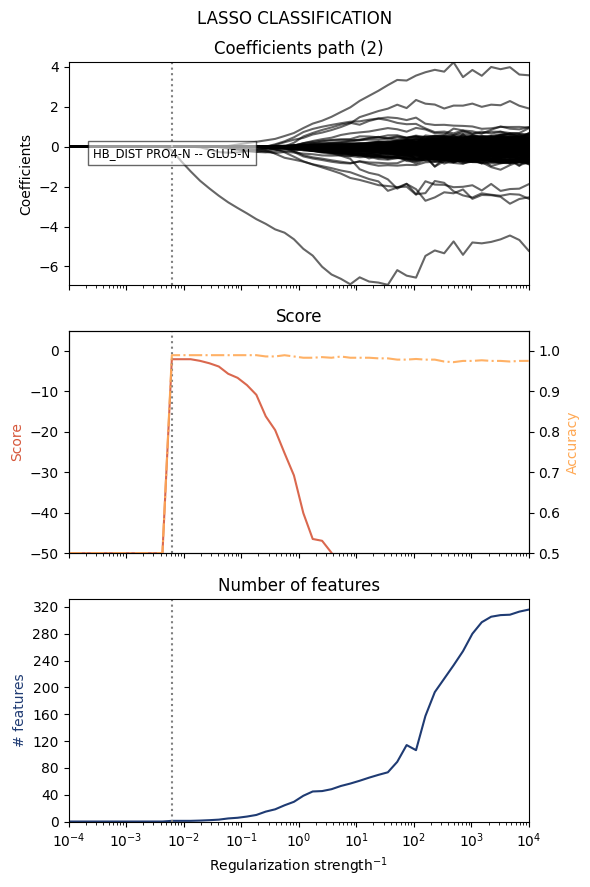

In [36]:
classifier, feats, coeffs = lasso_classification(dataset, Cs=50, plot=True)

Text(0, 0.5, 'Tica-3 $\\tau=$4.56ns')

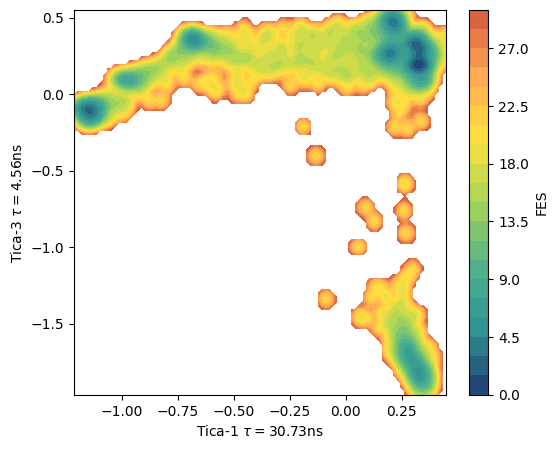

In [37]:
from mlcolvar.utils.fes import compute_fes
fig,ax = plt.subplots(1,1,figsize=(6,5),dpi=100)
max_fes = 30
# compute cvs
with torch.no_grad():
    s = torch.stack([r_fun[:, idx].real for idx in idxs]).T
fes,grid,bounds,error = compute_fes(s,
    blocks=1,
    bandwidth=0.01, scale_by='range',
    plot=False, plot_max_fes=200, ax = ax, eps=1e-10)

fes2 = fes.copy()
if max_fes is not None:
    fes2[fes2 > max_fes] = np.nan
extent = [item for sublist in bounds for item in sublist]
pp = ax.contourf(fes2, levels=20, cmap="fessa", extent=extent)  # ,vmax=max_fes)
cbar = plt.colorbar(pp, ax=ax)
cbar.set_label("FES")
# ax.set_xlim(-3, 2)
# ax.set_ylim(-3, 2)
plt.xlabel(f'Tica-{idxs[0] + 1} $\\tau=${taus[idxs[0]]:.2f}ns')
plt.ylabel(f'Tica-{idxs[1] + 1} $\\tau=${taus[idxs[1]]:.2f}ns')

/tmp/ipykernel_4006748/1615058839.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


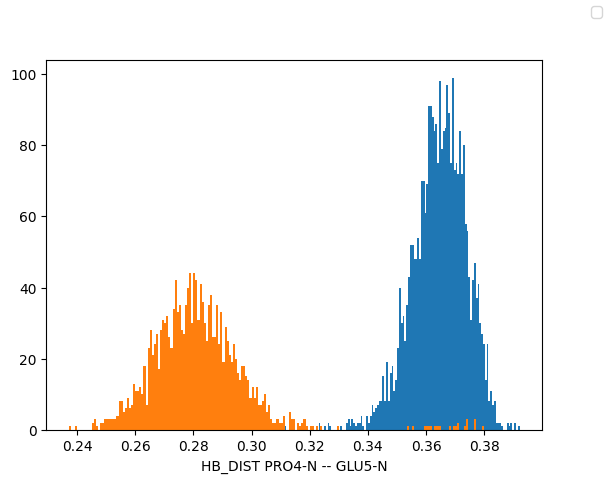

In [40]:
fig, ax = plt.subplots()
for k, feat in feats.items():
    colors = ['r', 'b']
    for lab_id, label in enumerate([1, 2]):
        mask = labels == label
        x = desc_df[feat[0]].values[mask]
        ax.hist(x, bins=200)
    ax.set_xlabel(feat[0])
fig.legend()

In [41]:
traj_1 = traj[::10][labels[::10] == 1]
traj_2 = traj[::10][labels[::10] == 2]

In [43]:
traj_1.save_pdb("CLN025_state_1.pdb")

In [44]:
traj_2.save_pdb("CLN025_state_2.pdb")

In [1]:
import mdtraj 
import nglview as nv

In [14]:
traj = mdtraj.load_trr("/media/novelli/DATA/calixarene/G1/traj/traj_com_0.trr", top="/media/novelli/DATA/calixarene/G1/data/no_water.gro")

In [15]:
nv.show_mdtraj(traj)

NGLWidget(max_frame=40356)